In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft

(256, 256)


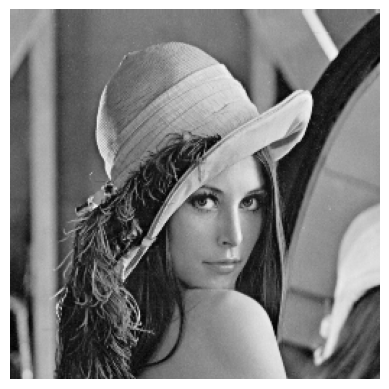

In [45]:
# import the image
img_lena = plt.imread('../Pictures/lena.tif')

print(img_lena.shape)

plt.imshow(img_lena, cmap='gray')
plt.axis('off')
plt.show()

In [44]:
# import the RGB image
img_01 = plt.imread('../Pictures/McM/McM01.tif')

'''
img_01.shape = (512, 512, 3)
where 3 means 3 channels: R, G, B
Extract three channels respectively
'''
img_01_R = img_01[:, :, 0]
img_01_G = img_01[:, :, 1]
img_01_B = img_01[:, :, 2]

# Step 1. Cut the image into patches

In [63]:
class Img2patch:
    def __init__(self):
        pass
    

    def __call__(self, *args, **kwargs):
        if kwargs.get('inv'):
            return self.patch2img(*args)
        else:
            return self.img2patch(*args)
    

    def img2patch(self, img, size, repeat_rate):
        '''
        Transform the image into patches

        Parameters
        ----------
        img : numpy.ndarray
            The input image
        size : int
            The size of the patch
        repeat_rate : float
            The rate of the overlapping area

        Returns
        -------
        patches : numpy.ndarray
            The patches of the image
        '''
        img_size = img.shape[0] # Number of pixels on each side

        # Cut image into patches
        d_ = int(size**0.5)
        h_ = d_ * (1 - repeat_rate)
        division_ = np.arange(0, img_size-d_+h_, h_).astype(int)

        patches_ = []
        DC_component_ = []

        for i in range(len(division_)):
            pi_ = division_[i]
            for j in range(len(division_)):
                pj_ = division_[j]
                patch_ = img[pi_:pi_+d_, pj_:pj_+d_]
                patch_ = patch_.reshape(-1, 1)

                DC_component_.append(np.mean(patch_))
                patch_ = patch_ - np.mean(patch_)
                patches_.append(patch_)

        patches_ = np.concatenate(patches_, axis=1)
        return patches_, DC_component_
    
    
    def patch2img(self, patches, repeat_rate, DC_component):
        '''
        Combining patches into an image

        Parameters
        ----------
        patches : numpy.ndarray
            The patches of the image
        repeat_rate : float
            The rate of the overlapping area
        DC_component : numpy.ndarray
            The DC component of each patch

        Returns
        -------
        img_ : numpy.ndarray
            The image
        '''
        P, N = patches.shape
        d_ = int(P**0.5)
        n_ = int(N**0.5)
        
        img_size_ = int(d_ * (n_ - (n_ - 1) * repeat_rate)) # Number of pixels on each side
        img_ = np.zeros((img_size_, img_size_)) # Initialize the image

        # Put the patch back in its place
        for idx in range(N):
            patch_ = patches[:, idx].reshape(d_, d_)
            i_ = int((idx // n_) * d_ * (1 - repeat_rate))
            j_ = int((idx % n_) * d_ * (1 - repeat_rate))
            
            # Add the DC component
            patch_ = patch_ + DC_component[idx]
            img_[i_:i_+d_, j_:j_+d_] = img_[i_:i_+d_, j_:j_+d_] + patch_

        # Average the overlapping area
        for j in range(1, n_):
            p_ = int(j * d_ * (1 - repeat_rate))
            img_[:, p_:p_+int(d_ * repeat_rate)] = img_[:, p_:p_+int(d_ * repeat_rate)] / 2

        for i in range(1, n_):
            p_ = int(i * d_ * (1 - repeat_rate))
            img_[p_:p_+int(d_ * repeat_rate), :] = img_[p_:p_+int(d_ * repeat_rate), :] / 2

        # Show the image
        plt.imshow(img_, cmap='gray')
        plt.axis('off')
        plt.show()
        return img_


Img2patch = Img2patch()

(256, 441)


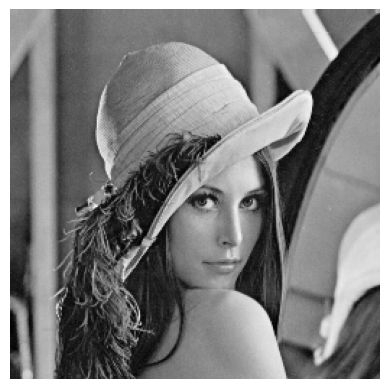

In [62]:
patches, DC_component = Img2patch(img_lena, 2**8, 0.25)
print(patches.shape)
img_new = Img2patch(patches, 0.25, DC_component, inv=True)

# Step 2

initial dictionary: DCT over-complete dictionary

In [5]:
# DCT over-complete dictionary
DCT = fft.dct(np.eye(128), norm='ortho', axis=0)[:64, :]
DCT = DCT / la.norm(DCT, axis=0)
print(DCT.shape)

(64, 128)


## Method 1: convex optimization

$$
\min_{D, A} \frac{1}{2} \| X-DA \|_F^2 + \lambda h(A)
$$

In [6]:
# intialization
D = DCT.copy()

In [7]:
def HuberLoss(A, eps=1e-3):
    mLoss_ = np.where(np.abs(A) <= eps, A**2 / 2, eps*np.abs(A) - eps**2/2)
    return np.sum(mLoss_)


def Phi(D, A, X=patches):
    E = X - D @ A
    return np.sum(E**2) / 2 + HuberLoss(A)

# Method 2: K-SVD

## OMP 稀疏编码

OMP（Orthogonal Matching Pursuit）是一种用于稀疏编码的算法，用于找到一组基向量的线性组合，最能够拟合给定观测信号的稀疏表示。其步骤如下：

- **初始化**：设输入信号为y，字典为D（包含一组基向量），稀疏表示向量为x（初始化为零向量）。
- **迭代**：
   1. 计算残差：$ r = y - Dx $。
   2. 选择最相关的原子：找到字典D中与残差r最相关（内积最大）的基向量，假设是第k个基向量。
   3. 更新稀疏表示：$x_k$（第k个系数）更新为$x_k = x_k + \langle d_k, r \rangle$，其中$d_k$是字典中的第k个基向量。
   4. 更新残差：$r = r - \langle d_k, r \rangle \cdot d_k$。
   5. 终止条件：检查稀疏表示向量x是否满足所需的稀疏度或残差大小要求，如果不满足，则继续迭代。

这个算法通过选择与当前残差最相关的基向量来逐步构建稀疏表示，直到达到所需的稀疏度或满足残差收敛要求。OMP是一种简单但有效的稀疏编码方法，在信号处理和压缩感知等领域得到广泛应用。

In [19]:
E = patches.copy()
A = np.zeros((D.shape[1], patches.shape[1]))

x = patches[:, 0]
a = A[:, 0]
e = x - D @ a

for idx in range(10000):
    j = np.argmax(e.T @ D)
    a[j] += e.T @ D[:, j]
    e = e - (e.T @ D[:, j]) * D[:, j]

    if np.count_nonzero(a) >= 48 or la.norm(e) < 1e-3:
        break

In [33]:
p = np.array([8, 8])
np.prod(p, p)

TypeError: only integer scalar arrays can be converted to a scalar index